In [1]:
import tensorflow as tf
import modules.tf.load_img as load_img
import importlib
import matplotlib.pyplot as plt
importlib.reload(load_img)


<module 'modules.tf.load_img' from '/home/taesookim/Documents/ML/tensorflow2_notebooks/modules/tf/load_img.py'>

In [2]:
import os
from tensorflow.keras import mixed_precision

In [3]:
os.environ['TF_XLA_FLAGS']="--tf_xla_enable_xla_devices"
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [4]:
tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [6]:
def seq(lyrs):
  return [tf.keras.models.Sequential(lyr) for lyr in lyrs]
import tensorflow as tf
def model_autoencoder():
  inp = tf.keras.layers.Input([16, 16, 1])

  layers = seq([tf.keras.layers.Conv2D(16, kernel_size=(4,4), strides=(2,2), padding="same", activation=tf.nn.leaky_relu),#8
                                tf.keras.layers.Conv2D(32, kernel_size=(4,4), strides=(2,2), padding="same", activation=tf.nn.leaky_relu),#4
                                tf.keras.layers.Conv2D(64, kernel_size=(4,4), strides=(2,2), padding="same", activation=tf.nn.leaky_relu),#2
                                tf.keras.layers.Conv2D(512, kernel_size=(2,2), strides=(2,2), padding="same", activation=tf.nn.leaky_relu),#1
                                tf.keras.layers.Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), padding="same", activation=tf.nn.leaky_relu),#2
                                tf.keras.layers.Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), padding="same", activation=tf.nn.leaky_relu),#4
                                tf.keras.layers.Conv2DTranspose(16, kernel_size=(4,4), strides=(2,2), padding="same", activation=tf.nn.leaky_relu),#8
                                tf.keras.layers.Conv2DTranspose(1, kernel_size=(4,4), strides=(2,2), padding="same", activation=tf.nn.tanh ) #16
          ])
  prev = inp
  skips = []
  for layer in layers[:4]:
    prev = layer(prev)
    skips.append(prev)

  skips = skips[:3]
  for skip, layer in zip(reversed(skips), layers[4:]):
    prev = layer(prev)
    prev = tf.keras.layers.concatenate([skip, prev])


  prev = layers[-1](prev)


  return tf.keras.Model(inputs=inp, outputs=prev)

model = model_autoencoder()

In [7]:
BATCH_SIZE = 32
GLOBAL_BATCH_SIZE = 32 * strategy.num_replicas_in_sync


In [8]:
checkpoint_dir = "./training_checkpoints_skips"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

with strategy.scope():
    model = model_autoencoder()
    loss_object = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
    def compute_loss(real, pred):
        per_example_loss = loss_object(real, pred)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)
    optimizer = tf.keras.optimizers.Adam()
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [9]:
with strategy.scope():
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 8, 8, 16)     272         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 4, 4, 32)     8224        sequential_8[0][0]               
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 2, 2, 64)     32832       sequential_9[0][0]               
____________________________________________________________________________________________

In [10]:
# train_imgs = load_img.load_mnist(GLOBAL_BATCH_SIZE, tiny=False)
# for data in train_imgs:
#     img, img_fn = data
#     img = img[0]
#     print(tf.reduce_min(img), tf.reduce_max(img))
#     pred = model(img)
#     print(tf.reduce_min(pred), tf.reduce_max(pred))
#     5/0

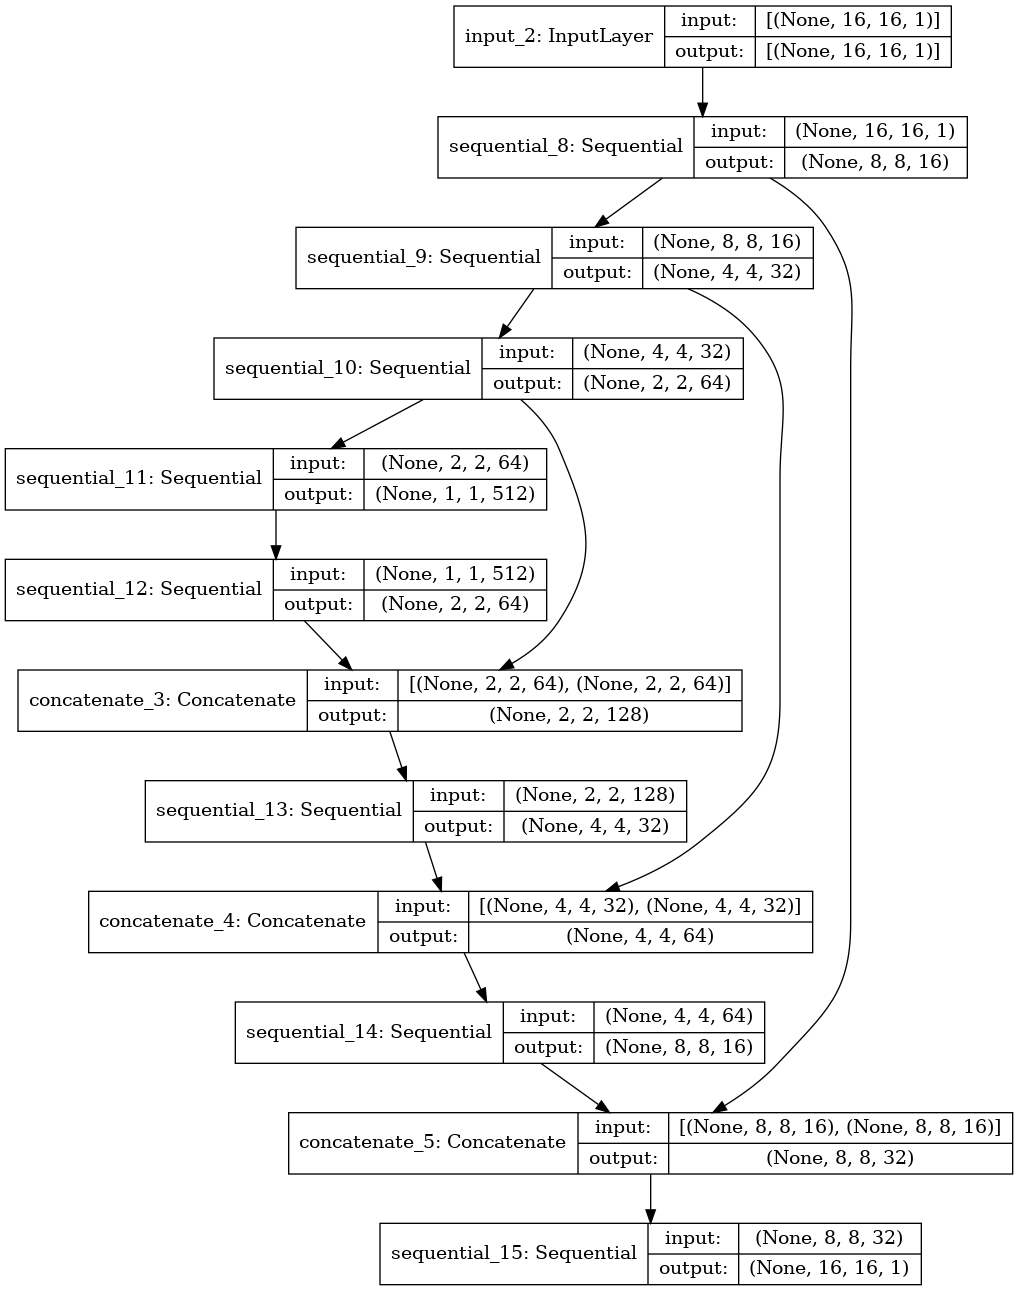

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
train_imgs = load_img.load_mnist(GLOBAL_BATCH_SIZE, tiny=False)
train_imgs = strategy.experimental_distribute_dataset(train_imgs)

In [13]:
@tf.function
def train_step(inputs):
    img, img_fn = inputs
    with tf.GradientTape() as tape:
        pred = model(img * 0.5, training=True)
        loss = compute_loss(img, pred)
        scaled_loss = optimizer.get_scaled_loss(loss)
    scaled_gradients = tape.gradient(scaled_loss, model.trainable_variables)
    gradients = optimizer.get_unscaled_gradients(scaled_gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def distributed_train_step(inputs):
    per_replica_losses = strategy.run(train_step, args=(inputs, ))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                           axis=None) / GLOBAL_BATCH_SIZE

In [14]:
loss = None
for epoch in range(50):
    for data in train_imgs:
        loss = distributed_train_step(data)
        tf.print(loss)
        5/0
        if tf.math.less(loss, .2):
            checkpoint.save(file_prefix=checkpoint_prefix)
            5/0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
0.209106445


ZeroDivisionError: division by zero

In [ ]:
checkpoint.save(file_prefix=checkpoint_prefix)

In [15]:
train_imgs = load_img.load_mnist(GLOBAL_BATCH_SIZE, tiny=False)

for data in train_imgs:
    img, img_fn = data
    img = img[0][tf.newaxis,...]
    print(tf.reduce_min(img), tf.reduce_max(img))
    pred = model(img)
    print(tf.reduce_min(pred), tf.reduce_max(pred))
    5/0

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-0.4006, shape=(), dtype=float16) tf.Tensor(1.0, shape=(), dtype=float16)


ZeroDivisionError: division by zero